# Experiments to improve classification accuracy &ndash; merged-average baseline

This notebook contains the experiments to improve classification accuracy that use the merged-average profile with all languages as a baseline, ignoring results on other profiles.

In [1]:
from IPython.display import display
import pandas as pd
import pylab
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

pylab.rcParams['figure.figsize'] = (10, 5)

## Looking at the new baseline results

In [2]:
LANGUAGE_CODE_TO_NAME = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'bg': 'Bulgarian',
    'bn': 'Bengali',
    'ca': 'Catalan',
    'cs': 'Czech',
    'da': 'Danish',
    'de': 'German',
    'el': 'Greek',
    'en': 'English',
    'es': 'Spanish',
    'et': 'Estonian',
    'fa': 'Persian',
    'fi': 'Finnish',
    'fr': 'French',
    'gu': 'Gujarati',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hr': 'Croatian',
    'hu': 'Hungarian',
    'id': 'Indonesian',
    'it': 'Italian',
    'ja': 'Japanese',
    'kn': 'Kannada',
    'ko': 'Korean',
    'lt': 'Lithuanian',
    'lv': 'Latvian',
    'mk': 'Macedonian',
    'ml': 'Malayalam',
    'mr': 'Marathi',
    'ne': 'Nepali',
    'nl': 'Dutch',
    'no': 'Norwegian',
    'pa': 'Punjabi',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'si': 'Sinhalese',
    'sk': 'Slovak',
    'sl': 'Slovene',
    'so': 'Somali',
    'sq': 'Albanian',
    'sv': 'Swedish',
    'sw': 'Swahili',
    'ta': 'Tamil',
    'te': 'Telugu',
    'th': 'Thai',
    'tl': 'Tagalog',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'ur': 'Urdu',
    'vi': 'Vietnamese',
    'zh-cn': 'Simplified Chinese',
    'zh-tw': 'Traditional Chinese'
}

RESULT_PARAM_COLS = ['datasetName', 'substringLength', 'sampleSize', 'profileParam', 'useAllLanguages']

In [3]:
def read_results(path):
    """
    Read results from the given path, dropping all results except for merged-average on all languages.
    """
    results = pd.read_csv(path)
    return results[(results['profileParam'] == 'merged-average') & results['useAllLanguages']]

baseline_results = read_results(
    '../src/test/resources/org/xbib/elasticsearch/index/mapper/langdetect/accuracies.csv'
)
baseline_results.T.head(10).T.head()

,datasetName,substringLength,sampleSize,profileParam,useAllLanguages,af,ar,bg,bn,ca
3,udhr,0,1,merged-average,True,1,1,1,1,1
9,udhr,5,100,merged-average,True,0.35,0.87,0.39,1,0.15
15,udhr,10,100,merged-average,True,0.6,0.98,0.58,1,0.45
21,udhr,20,100,merged-average,True,0.77,0.99,0.84,1,0.73
27,udhr,50,100,merged-average,True,0.97,1,0.92,1,0.97


## Experiment: one-skip-bigrams

What happens when we add one-skip bigrams extracted from the profile trigrams (e.g., "the" -> "te")...?
Not much in terms of positive results. This may be because one-skip bigrams don't encode that much extra information and just add noise.

In [4]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=one-skip-bigrams \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/one-skip-bigrams.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 25.817 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


In [5]:
one_skip_bigrams_results = read_results('results/one-skip-bigrams.csv')

Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: -0.006103


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,165,0.50000,40,0.727273
positive,65,0.19697,10,0.181818
zero,100,0.30303,5,0.090909


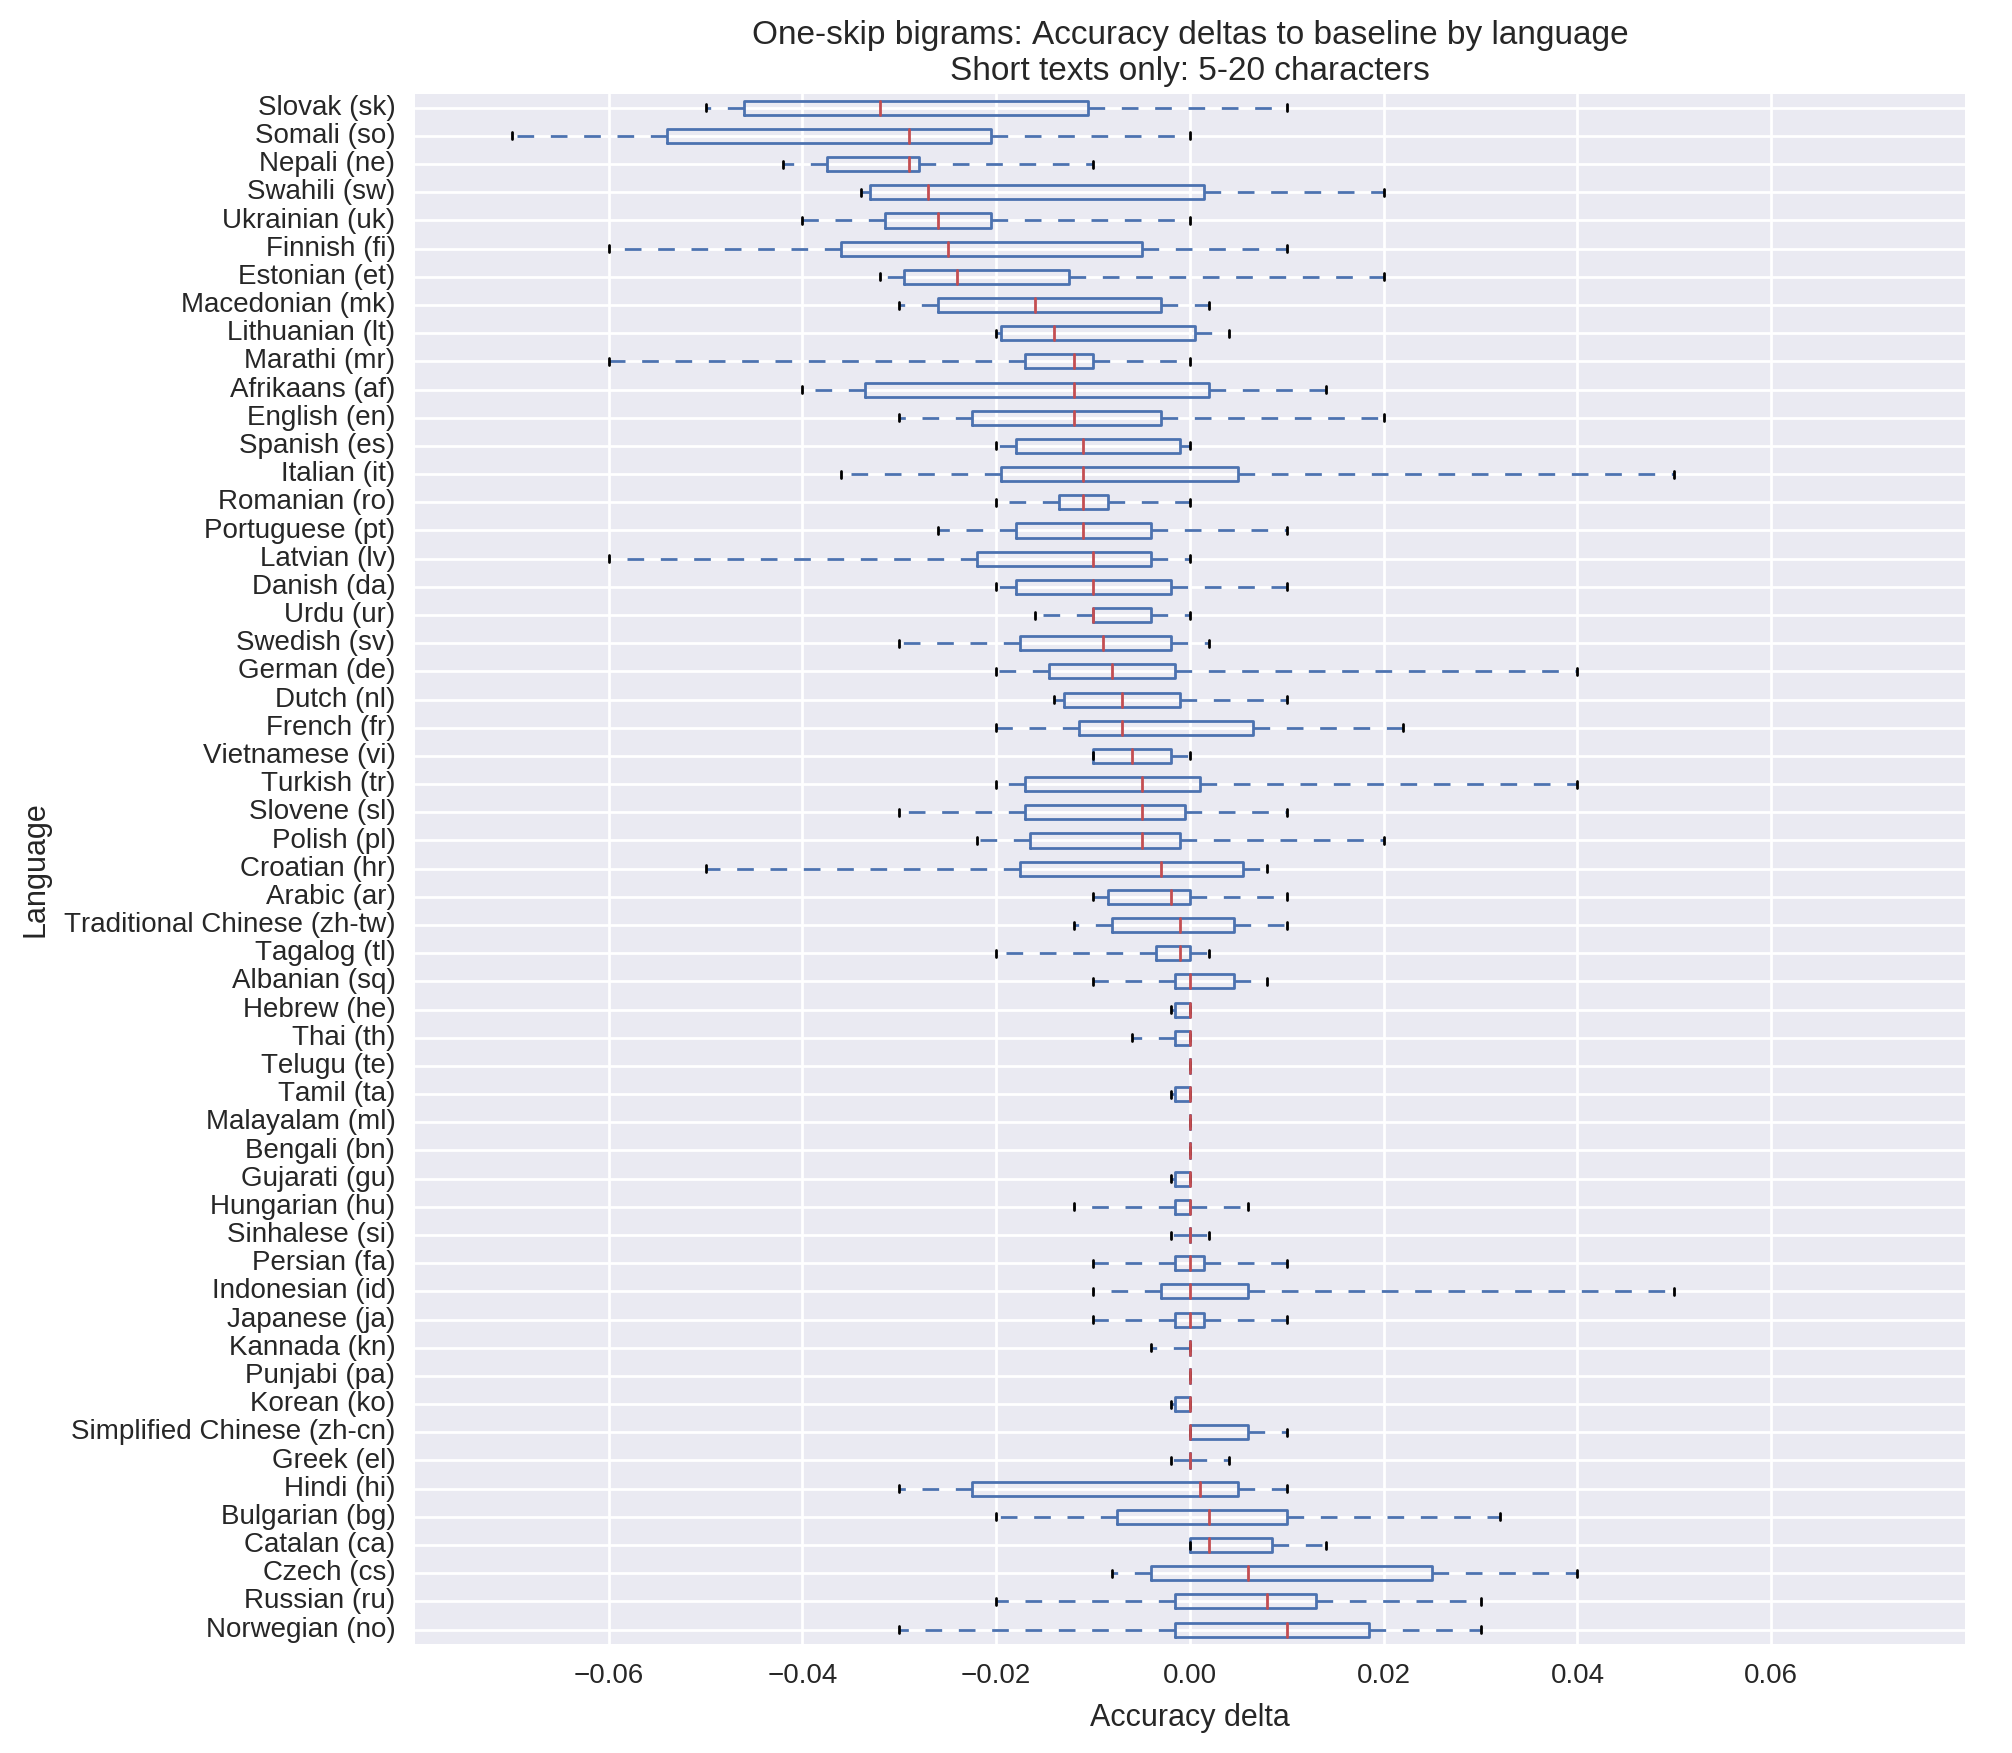

In [6]:
def extract_accuracies(results, short_only):
    if short_only:
        results = results[results['substringLength'].isin({5, 10, 20})]
    accuracies = results.drop(RESULT_PARAM_COLS, axis=1)
    accuracies.rename_axis({k: '{} ({})'.format(v, k) for k, v in LANGUAGE_CODE_TO_NAME.items()},
                           axis=1, inplace=True)
    return accuracies

def plot_accuracy_deltas_by_language(baseline_results, experiment_results, experiment_name='N/A',
                                     order='median', baseline_desc=None, quiet=False, short_only=True):
    baseline_accuracies = extract_accuracies(baseline_results, short_only)
    experiment_accuracies = extract_accuracies(experiment_results, short_only)
    assert len(baseline_accuracies) == len(experiment_accuracies)
    baseline_accuracies.index = experiment_accuracies.index
    deltas = (experiment_accuracies - baseline_accuracies).dropna(axis=1, how='all')
    delta_counts = pd.Series({k: v.sum().sum() for k, v in dict(positive=deltas > 0,
                                                                negative=deltas < 0,
                                                                zero=deltas == 0).items()})
    delta_means = deltas.mean()
    delta_mean_counts = pd.Series(dict(positive=(delta_means > 0).sum(),
                                       negative=(delta_means < 0).sum(),
                                       zero=(delta_means == 0).sum()))
    count_summary_df = pd.DataFrame({
        'Delta count': delta_counts,
        'Delta percent': delta_counts / delta_counts.sum(),
        'Language mean delta count': delta_mean_counts,
        'Language mean delta percent': delta_mean_counts / delta_mean_counts.sum()
    })
    mean_delta = deltas.mean().mean()
    if quiet:
        return count_summary_df, mean_delta
    print('Result summary (positive is better than the baseline)\n')
    print('Number of results: {}'.format(delta_counts.sum()))
    print('Number of languages: {}'.format(len(deltas.columns)))
    print('Mean delta: {:4f}'.format(mean_delta))
    display(count_summary_df)

    if order == 'width':
        order_series = deltas.max() - deltas.min()
    else:
        order_series = getattr(deltas, order)()
    ax = deltas[order_series.sort_values(ascending=False).index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    positive_limit = deltas.abs().max().max() + 0.01
    # Keep the x-axis symmetrical
    ax.set_xlim((-positive_limit, positive_limit))
    ax.set_xlabel('Accuracy delta')
    ax.set_ylabel('Language')
    ax.set_title('{} Accuracy deltas to baseline{} by language{}'.format(
        experiment_name,
        ' ({})'.format(baseline_desc) if baseline_desc else '',
        '\nShort texts only: 5-20 characters' if short_only else ''
    ))

plot_accuracy_deltas_by_language(baseline_results,
                                 one_skip_bigrams_results,
                                 'One-skip bigrams:')

## Experiment: lowercase

What happens when we replace uppercase ngrams with lowercase ngrams? Nothing too exciting either, possibly because some WP placeholders don't get filtered out (no more all-capitals words).

In [7]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=lowercase \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/lowercase.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 23.929 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: 0.000406


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,134,0.406061,33,0.600000
positive,84,0.254545,21,0.381818
zero,112,0.339394,1,0.018182


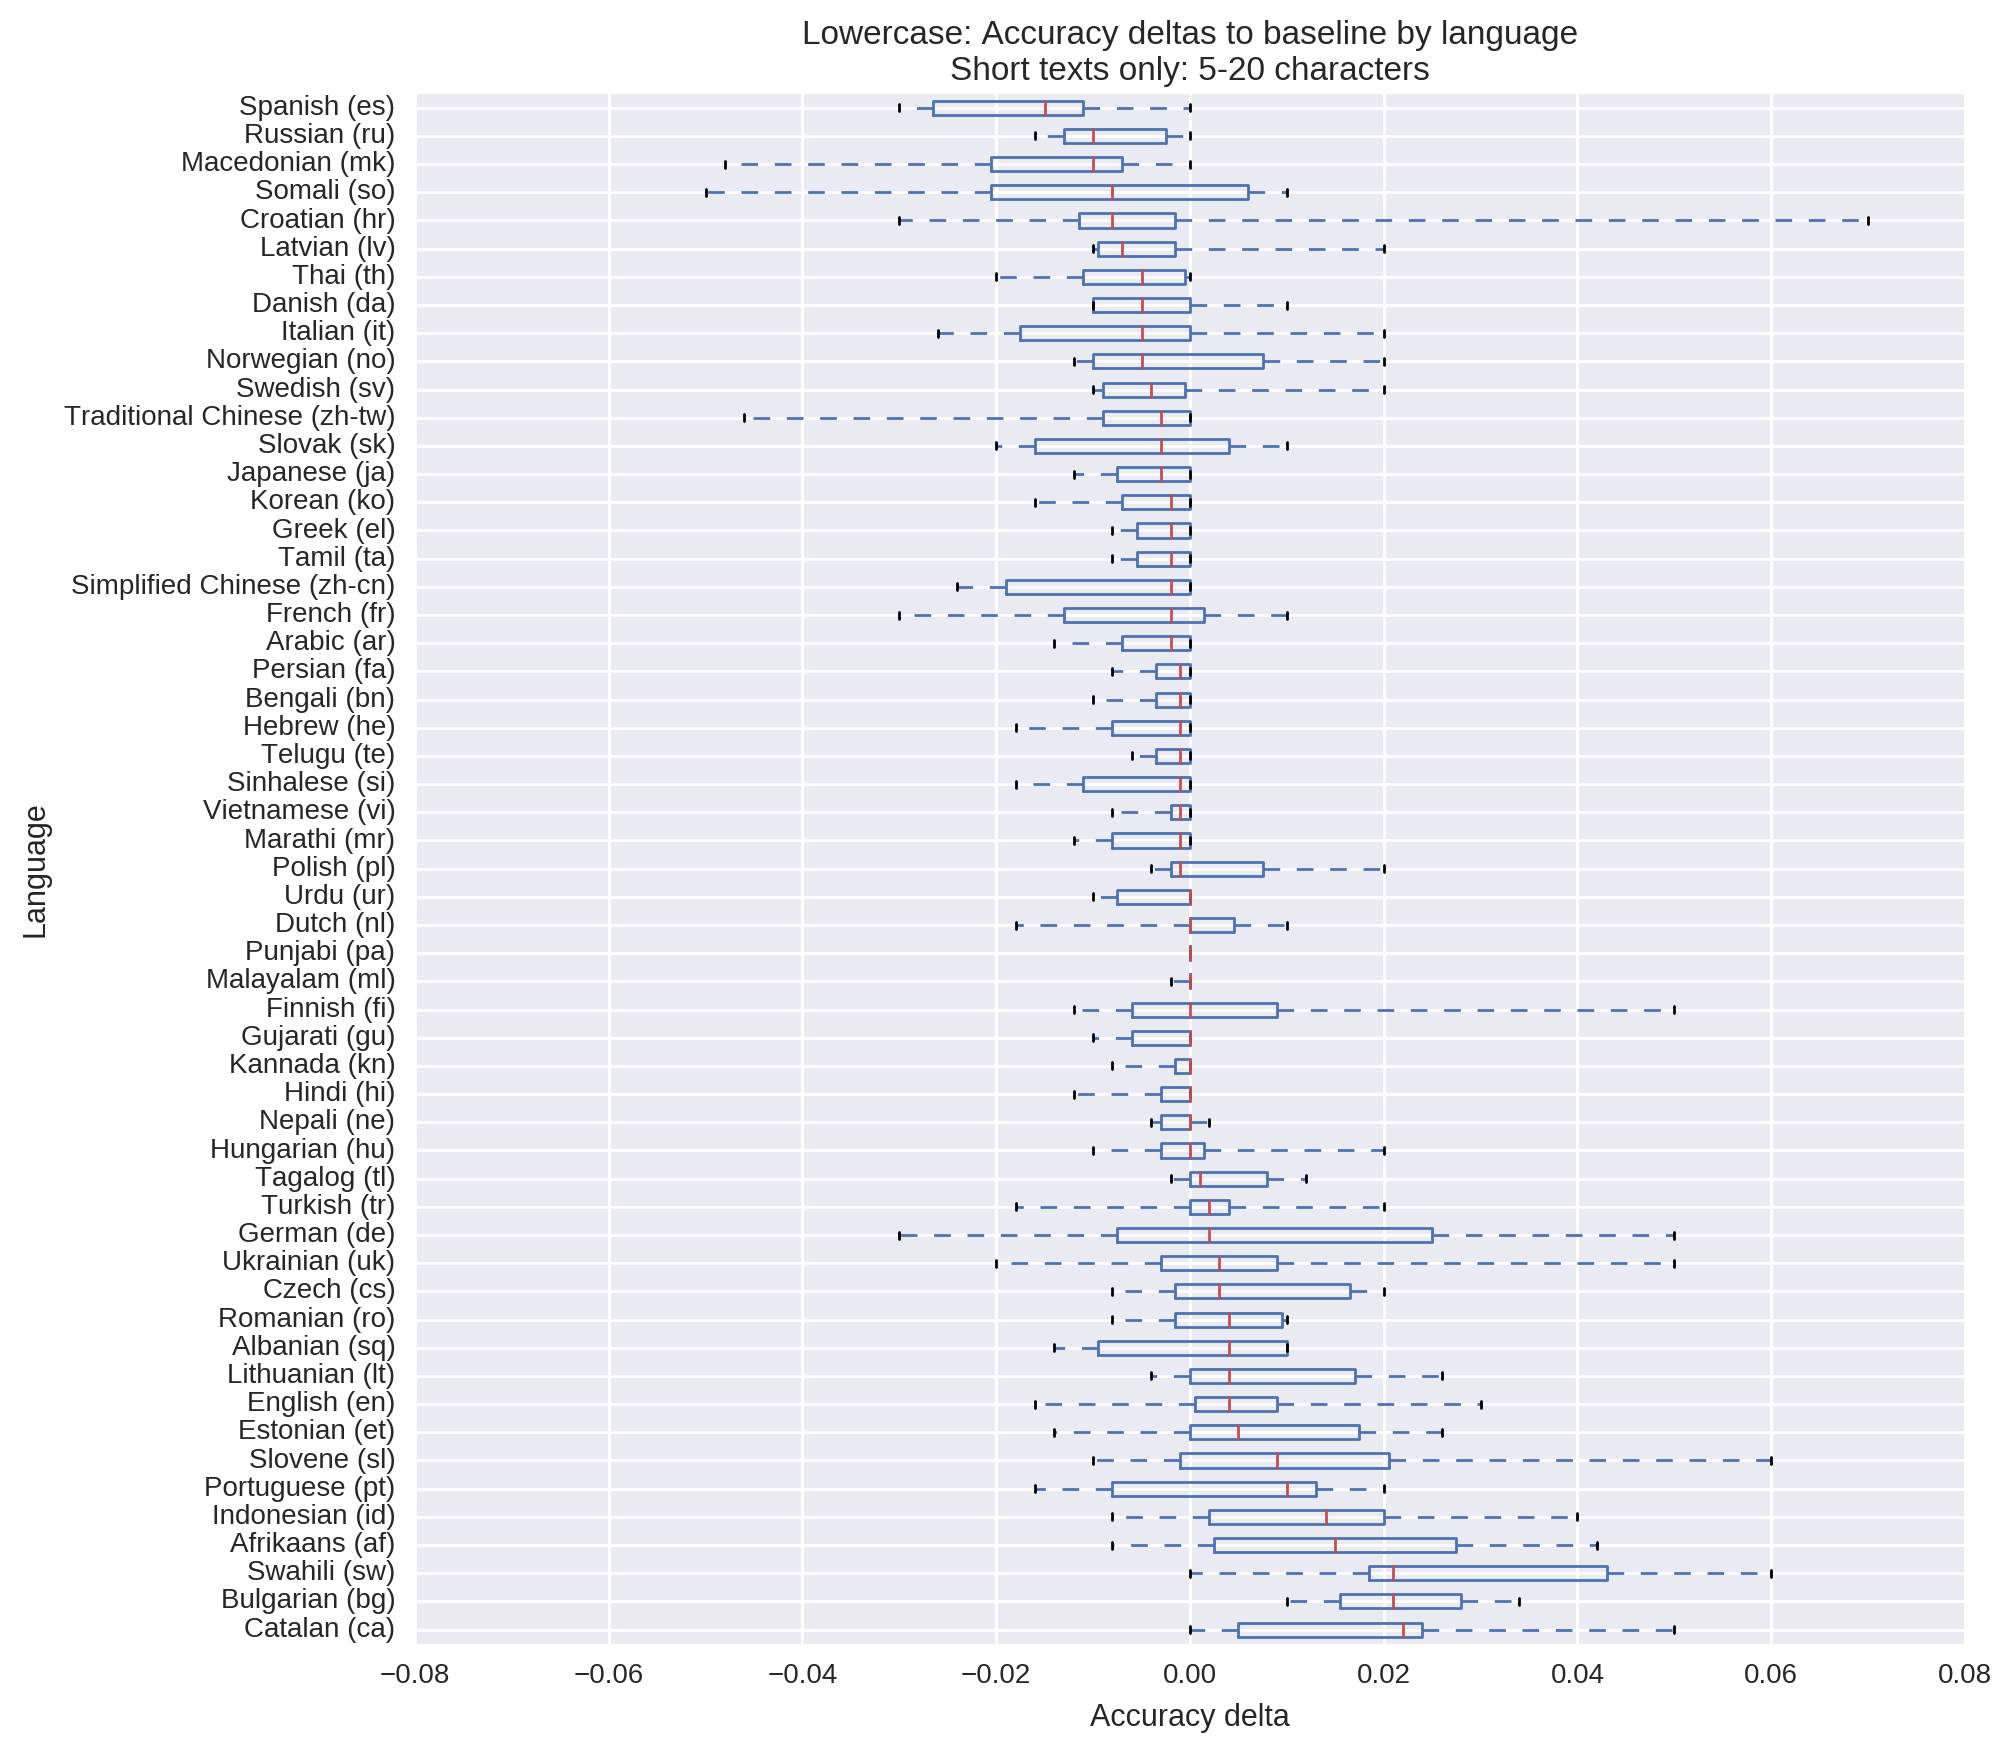

In [8]:
lowercase_results = read_results('results/lowercase.csv')
plot_accuracy_deltas_by_language(baseline_results, lowercase_results, 'Lowercase:')